# Baseline STFT Spectrogram Multilayer Perceptron

This notebook investigates the effect of different input spectrograms on the performance of a simple MLP model.

### Model 1 - perceptron
- input: ~0.038s of audio (spectrogram)
- 1 hidden layer, size 1000, ReLU activation
- output: note predictions the middle of the receptive field

#### Experiments
- STFT, window size 512, hop size 147 (1/300 of a second), **accuracy**: 23%
- STFT, window size 1024, hop size 147, **accuracy**: 31%
- STFT, window size 2048, hop size 147, **accuracy**: 34%
- STFT, window size 4096, hop size 147, **accuracy**: 36%
- CQT, 12/24 bins per octave, hop size 128/512, 6/7 octaves, **accuracy**: 32-36%
- CQT, 6 bins per octave, 512 hop size, 8 octaves, **accuracy**: 16%
- MFCC, 160 mels, **accuracy**: 34%
- MFCC, 40 mels, **accuracy**: 26%

The accuracies are after 3 epochs of training on a subset of MusicNet

#### Discussion
The most important characteristic of a well suited spectrogram for f0 estimation is (unsurprisingly) a good enough frequency resolution. When the resolution is too low to distinguish individual notes, the accuracy drops by 10%.
Other than that the spectrograms performed more or less the same with different configurations. More precisely the accuracy was not affected by linear/logarithmic frequency axis, by use of STFT/CQT/MFCC, by a decrease of the time resolution, by omitting information about frequencies above 7040Hz.
Since the accuracy of the model is not very high (similar to equivalent model run on raw samples), we cannot generalize these findings on deeper models.

### Model 2 - frequency convolution
- input: ~0.038s of audio (spectrogram)
- conv1: 4 filters, 128x1 kernel, 2x1 stride, same padding, relu activation
- conv2: 8 filter, 64x3 kernel, 2x1 stride, same padding, relu activation
- output: note predictions the middle of the receptive field

#### Motivation
The wide convolution across frequency axis should be able to pick up the fundamental frequency and the harmonics of a melodic instrument. If this is true, the model accuracy will be much better in spectrograms where the frequency axis is logarithmic (CQT in our case) since the distances between the harmonics stay the same independently on the fundamental.

#### Experiments
- CQT, 20 bins per octave, 8 octaves, 512 hop size, log-scaled power magnitude, **accuracy**: 40%
- STFT, 4096 window size, 512 hop size, log-scaled power magnitude, **accuracy**: 41%
- Multivariate linear regression (no hidden layer), **accuracy**: 40%

#### Discussion
The experiments didn't confirm the hypothesis, the accuracies on CQT and STFT are the same. The additional experiment based on linear regression results also in 40% accuracy. That means that the more complex models were not able to extract more information from the input and so either the models are not well designed or it is not possible to reach significantly better results with such a small audio window. In the next experiment the window size is 10x wider.

### Model 3 - two layer convolution
- input: ~0.38s of audio (spectrogram)
- conv1: 4 filters, 128x1 kernel, 2x1 stride, same padding, relu activation
- conv2: 8 filter, 64x5 kernel, 1x1 stride, valid padding, relu activation
- output: note predictions the middle of the receptive field

#### Experiments
- CQT, 20 bins per octave, 8 octaves, 512 hop size, log-scaled power magnitude, **accuracy**: 45%
- STFT, 4096 window size, 512 hop size, log-scaled power magnitude, **accuracy**: 42%
- CQT, Multivariate linear regression (no hidden layer), **accuracy**: 38%
- CQT, NN with one hidden layer (14560 nodes), **accuracy**: 39%

#### Discussion 
This set of experiments has expected results according to the hypothesis. Convolutions are better than the simple models and STFT performs worse than CQT. This might confirm that CQT is more suitable as an input for convolutional networks, since the convolutions are able to exploit the regularity in tone harmonic frequencies.

In [1]:
# for automatic reloading of my libraries
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np

import datasets
from model import Network

import visualization as vis
import librosa

import datetime
MUSICNET_ROOT = "/home/jirka/bakalarka/melody_extraction/datasets/musicnet"

/home/jirka/bakalarka/jupyter-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
X, sr = librosa.load(MUSICNET_ROOT+"/test_data/2303.wav", sr=None)

(320, 345)
-stft4096-hop512-crop320


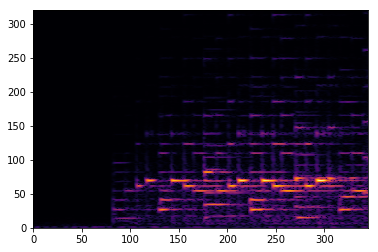

In [56]:
import matplotlib
import matplotlib.pyplot as plt

# hop_length = 147*3
hop_length = 512
crop = 320
n_fft = 4096
log_scale = 1

# mfcc
fmin = 55
fmax = 7040
n_mels = 40

# cqt
bins_per_octave = 32
n_bins = bins_per_octave*8


def spec_function_stft(audio, samplerate):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)[:crop]
    return np.log(1+np.abs(stft)).astype(np.float16)
spectrogram_thumbprint_stft = "-stft{}-hop{}-crop{}".format(n_fft, hop_length, crop, log_scale)

def spec_function_mfcc(audio, samplerate):
    mfcc = librosa.feature.melspectrogram(audio, samplerate, n_fft=2048, hop_length=hop_length, fmin=fmin, fmax=fmax, n_mels=n_mels)
    return np.log(1+10000*mfcc).astype(np.float16)
spectrogram_thumbprint_mfcc = "-mfcc{}_{}-hop{}-nmels{}".format(fmin, fmax, hop_length, n_mels)

def spec_function_cqt(audio, samplerate):
    cqt = librosa.core.cqt(audio, sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)
    #return librosa.amplitude_to_db(np.abs(cqt), ref=np.max)
    return np.log(1+100*np.abs(cqt)).astype(np.float16)
spectrogram_thumbprint_cqt = "-cqt-fmin{}-octaves{}-octbins{}-hop{}-log100".format(fmin, n_bins/bins_per_octave, bins_per_octave, hop_length)

spec_function = spec_function_stft
spectrogram_thumbprint = spectrogram_thumbprint_stft

y = spec_function(X[:4*sr], sr)
print(y.shape)
print(spectrogram_thumbprint)

plt.pcolormesh(y, cmap="inferno")

In [57]:
# clear memory
test_dataset = None
train_dataset = None


samplerate = 16000
print("test data loading")
test_data = datasets.musicnet_dataset(MUSICNET_ROOT, "test")
print("train data loading")
train_data = datasets.musicnet_dataset(MUSICNET_ROOT, "train", 60)
# train_data = datasets.musicnet_dataset(MUSICNET_ROOT, "train")

def load_all(data, samplerate):
    for i,d in enumerate(data):
        d.audio.load_spectrogram(spec_function, spectrogram_thumbprint, hop_length)
        print(".", end=("" if (i+1) % 20 else "\n"))
print("---")
print("test data loading")
load_all(test_data, 16000)
print("\ntrain data loading")
load_all(train_data, 16000)

test data loading
..........
train data loading
....................
....................
....................

---
test data loading
..........
train data loading
....................
....................
....................


In [58]:
annotations_per_window = 1
context_width = hop_length*16

test_dataset = datasets.AADataset(test_data, annotations_per_window, context_width, shuffle_batches=False)
train_dataset = datasets.AADataset(train_data, annotations_per_window, context_width, shuffle_batches=True)

In [59]:
# small dataset for manual evaluation
small_test_data = [
    test_data[3].slice(15,20.8), # solo cello
    test_data[9].slice(56,61.4), # solo piano
    test_data[5].slice(55.6,61.6), # orchestra
    test_data[2].slice(17.65,27), # violin + string section
]
small_test_dataset = datasets.AADataset(small_test_data, annotations_per_window, context_width, shuffle_batches=False)

(320, 32)


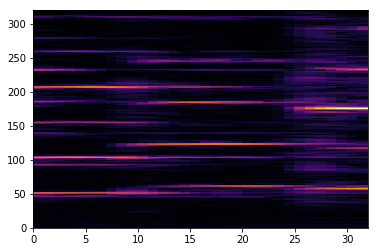

In [60]:
b = small_test_dataset.next_batch(100)[-1]
x = b["spectrogram"]
print(x.shape)
# librosa.display.specshow(x, y_axis='linear', x_axis='time')
plt.pcolormesh(x, cmap="inferno")

In [61]:
def create_model_simple(self, args):
    def conv(inputs, filters, size, strides, padding, activation=None, dilation_rate=1, training=False):
        name = "conv{}-f{}-s{}-dil{}-{}".format(size, filters, strides, dilation_rate, padding)
        name = name.replace(" ", "").replace("(","").replace(")","").replace(",","x")
        return tf.layers.conv2d(inputs, filters, size, strides, padding, activation=activation, dilation_rate=dilation_rate, name=name)

    audio_net = self.spectrogram
    audio_net = tf.layers.flatten(audio_net)
    # audio_net = tf.layers.dense(audio_net, 14560, activation=tf.nn.relu, name="hidden")

    output_layer = tf.layers.dense(audio_net, self.note_range*self.annotations_per_window, activation=None, name="output")

    self.note_probabilites = tf.reshape(output_layer, [-1, self.annotations_per_window, self.note_range])
    self.est_notes = tf.cast(tf.greater(self.note_probabilites, 0), tf.float32)
    
    ref_notes_flat = tf.layers.flatten(self.ref_notes)
    self.loss = tf.losses.sigmoid_cross_entropy(ref_notes_flat, output_layer)

    global_step = tf.train.create_global_step()
    self.training = tf.train.AdamOptimizer().minimize(self.loss, global_step=global_step)

In [62]:
def create_model_conv(self, args):
    def conv(inputs, filters, size, strides, padding, activation=None, dilation_rate=1, training=False):
        name = "conv{}-f{}-s{}-dil{}-{}".format(size, filters, strides, dilation_rate, padding)
        name = name.replace(" ", "").replace("(","").replace(")","").replace(",","x")
        return tf.layers.conv2d(inputs, filters, size, strides, padding, activation=activation, dilation_rate=dilation_rate, name=name)

    # audio_net = self.spectrogram[:,42:44,:]
    audio_net = self.spectrogram
    audio_net = tf.expand_dims(audio_net, axis=3)
    print(audio_net.shape)
    # audio_net = conv(audio_net, 32, (3, 3), (2, 2), "same", tf.nn.relu)
    audio_net = conv(audio_net, 4, (128, 1), (2, 1), "same", tf.nn.relu)
    print(audio_net.shape)
    audio_net = conv(audio_net, 8, (64, 5), (1, 1), "valid", tf.nn.relu)
    print(audio_net.shape)
    audio_net = tf.layers.flatten(audio_net)
    #audio_net = tf.layers.dense(audio_net, 1000, activation=tf.nn.relu, name="hidden")
    output_layer = tf.layers.dense(audio_net, self.note_range*self.annotations_per_window, activation=None, name="output")

    self.note_probabilites = tf.reshape(output_layer, [-1, self.annotations_per_window, self.note_range])
    self.est_notes = tf.cast(tf.greater(self.note_probabilites, 0), tf.float32)
    
    ref_notes_flat = tf.layers.flatten(self.ref_notes)
    self.loss = tf.losses.sigmoid_cross_entropy(ref_notes_flat, output_layer)

    global_step = tf.train.create_global_step()
    self.training = tf.train.AdamOptimizer().minimize(self.loss, global_step=global_step)

In [63]:
def create_model_conv(self, args):
    def conv(inputs, filters, size, strides, padding, activation=None, dilation_rate=1, training=False):
        name = "conv{}-f{}-s{}-dil{}-{}".format(size, filters, strides, dilation_rate, padding)
        name = name.replace(" ", "").replace("(","").replace(")","").replace(",","x")
        return tf.layers.conv2d(inputs, filters, size, strides, padding, activation=activation, dilation_rate=dilation_rate, name=name)

    # audio_net = self.spectrogram[:,42:44,:]
    audio_net = self.spectrogram
    audio_net = tf.expand_dims(audio_net, axis=3)
    print(audio_net.shape)
    # audio_net = conv(audio_net, 32, (3, 3), (2, 2), "same", tf.nn.relu)
    audio_net = conv(audio_net, 4, (128, 1), (2, 1), "same", tf.nn.relu)
    print(audio_net.shape)
    audio_net = conv(audio_net, 8, (64, 5), (1, 1), "valid", tf.nn.relu)
    print(audio_net.shape)
    audio_net = tf.layers.flatten(audio_net)
    #audio_net = tf.layers.dense(audio_net, 1000, activation=tf.nn.relu, name="hidden")
    output_layer = tf.layers.dense(audio_net, self.note_range*self.annotations_per_window, activation=None, name="output")

    self.note_probabilites = tf.reshape(output_layer, [-1, self.annotations_per_window, self.note_range])
    self.est_notes = tf.cast(tf.greater(self.note_probabilites, 0), tf.float32)
    
    ref_notes_flat = tf.layers.flatten(self.ref_notes)
    self.loss = tf.losses.sigmoid_cross_entropy(ref_notes_flat, output_layer)

    global_step = tf.train.create_global_step()
    self.training = tf.train.AdamOptimizer().minimize(self.loss, global_step=global_step)


In [64]:
create_model = create_model_conv
example_input = test_dataset.next_batch(1)[0]

restore = None

# Create logdir name
args = {
    "threads": 6,
    "batch_size": 64,
    "logdir": None,
    "annotations_per_window": test_dataset.annotations_per_window,
    "window_size": test_dataset.window_size,
    "note_range": 96,
    "samplerate": test_dataset.samplerate,
    "spectrogram_shape": example_input["spectrogram"].shape
}
name = "{}-bs{}-apw{}-wsiz{}-{}".format(
    datetime.datetime.now().strftime("%m-%d_%H%M%S"),
    args["batch_size"],
    args["annotations_per_window"],
    args["window_size"],
    spectrogram_thumbprint
)

if restore:
    name = restore
args["logdir"] = "models/" + name

print(name)

# Construct the network
network = Network(threads=args["threads"])
network.construct(args, create_model)

if restore:
    network.restore()

08-18_110141-bs64-apw1-wsiz16825--stft4096-hop512-crop320
(?, 320, 32, 1)
(?, 160, 32, 4)
(?, 97, 28, 8)


In [65]:
epochs = 3
batch_size = args["batch_size"]
try:
    network.train(train_dataset, test_dataset, small_test_dataset, batch_size, epochs, eval_every_n_batches=10000, save_every_n_batches=20000)
except KeyboardInterrupt:
    print('Graceful Exit')

=== epoch 1 ===
.....b 1000; t 29.29; acc 0.42; loss 0.06
.....b 2000; t 29.35; acc 0.46; loss 0.06
.....b 3000; t 29.59; acc 0.53; loss 0.05
.....b 4000; t 29.38; acc 0.48; loss 0.05
.....b 5000; t 29.54; acc 0.46; loss 0.06
.....b 6000; t 29.67; acc 0.51; loss 0.05
.....b 7000; t 29.55; acc 0.44; loss 0.06
.....b 8000; t 29.42; acc 0.47; loss 0.06
.....b 9000; t 29.39; acc 0.52; loss 0.05
.....b 10000; t 29.73; acc 0.50; loss 0.05
epoch 1, batch 10000, t 45.02, accuracy: 0.43
.....b 11000; t 29.36; acc 0.54; loss 0.04
.....b 12000; t 29.61; acc 0.46; loss 0.05
.....b 13000; t 29.52; acc 0.58; loss 0.05
.....b 14000; t 29.43; acc 0.51; loss 0.05
.....b 15000; t 29.64; acc 0.50; loss 0.05
.....b 16000; t 29.68; acc 0.53; loss 0.05
.....b 17000; t 29.53; acc 0.56; loss 0.05
.....b 18000; t 29.61; acc 0.48; loss 0.05
.....b 19000; t 29.53; acc 0.50; loss 0.05
.....b 20000; t 29.60; acc 0.56; loss 0.05
epoch 1, batch 20000, t 44.98, accuracy: 0.43
Model saved in path: models/08-18_110141-

Model saved in path: models/08-15_213046-bs64-apw1-wsiz3513--cqt-fmin55-octaves6.0-octbins20-hop512-log/model.ckpt
Testing dataset metrics:
Precision 0.556159116123956
Recall 0.47844471129337396
Accuracy 0.3462421348199463
Substitution Error 0.19405140869801638
Miss Error 0.32750388000860964
False Alarm Error 0.1877697597226785
Total Error 0.7093250484293045
Chroma Precision 0.6125931266522471
Chroma Recall 0.5269929650062873
Chroma Accuracy 0.3952626346735547
Chroma Substitution Error 0.14550315498510302
Chroma Miss Error 0.32750388000860964
Chroma False Alarm Error 0.1877697597226785
Chroma Total Error 0.6607767947163912

Small testing dataset metrics:
Precision 0.4903145823647916
Recall 0.46577359046076844
Accuracy 0.31382662170204323
Substitution Error 0.22125717650522597
Miss Error 0.3129692330340056
False Alarm Error 0.26291770940674225
Total Error 0.7971441189459738
Chroma Precision 0.5533860220052689
Chroma Recall 0.5256882084498748
Chroma Accuracy 0.3690956072351421
Chroma Sub

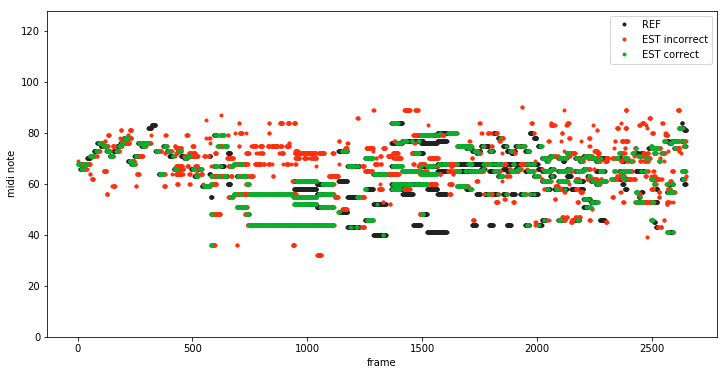

In [223]:
network.save()
print("Testing dataset metrics:")
acc = network.evaluate(test_dataset, args["batch_size"], print_detailed=True)
print("\nSmall testing dataset metrics:")
acc = network.evaluate(small_test_dataset, args["batch_size"], visual_output=True, print_detailed=True)

In [16]:
# play the small testing dataset
vis.samplesplayer(small_test_dataset.all_samples(), small_test_dataset.samplerate)

ValueError: zero-size array to reduction operation maximum which has no identity